# Multi-exponential fitting of multi-echo 3D UTE SPGR data

## Setup

In [1]:
# std library imports
import os
import sys

# 3rd-party library imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# local library imports
sys.path.append('/home/dharshan/Code/Work/UCSF-qMRI/qmri-toolbox')
from pyqmri.img_utils import view_utils as vu
from pyqmri.phantom_util import material_phantoms as mp_util
from pyqmri.signal_models import gre_3dute

progress = vu.SimpleProgress()

## Prepare data

### Load data
First, read echo times and convert to seconds (from microseconds)

In [2]:
# read TE list
ute_list = []
with open('multi_utes.dat', 'r') as utes_file:
    ute_info = utes_file.readlines()
    multi_utes_fname = ute_info.pop(0)
    num_utes = int(ute_info.pop(0).split()[-1])
    
    for ii in range(num_utes):
        ute_list.append(float(ute_info[ii]) * 1e-6) # convert to seconds
        
print('Echo times (microseconds): \n', np.array(ute_list)*1e6)

Echo times (microseconds): 
 [  24.   32.   52.   76.  112.  168.  248.  368.  544.  804.  992. 1188.
 1584. 1784. 1984. 2380. 2576. 2776. 3172. 3568.]


Load reconstructed images

In [3]:
with h5py.File('data/recon_multi-ute.mat','r') as recon_mat:
    recon_ims_all_echoes = recon_mat['imall'].value


Determine resolution and image dimensions (voxel dimensions assumed based on specified target resolution) --a more principled approach would use information from raw data or DICOM headers

In [4]:
# Get voxel dimensions

# !!!--KLUDGE (temporary)--!!!
dx = 2
dy = 2
dz = 2

(nz, ny, nx) = recon_ims_all_echoes.shape[-3:]

### View slices
Plot a few slices as a sanity check

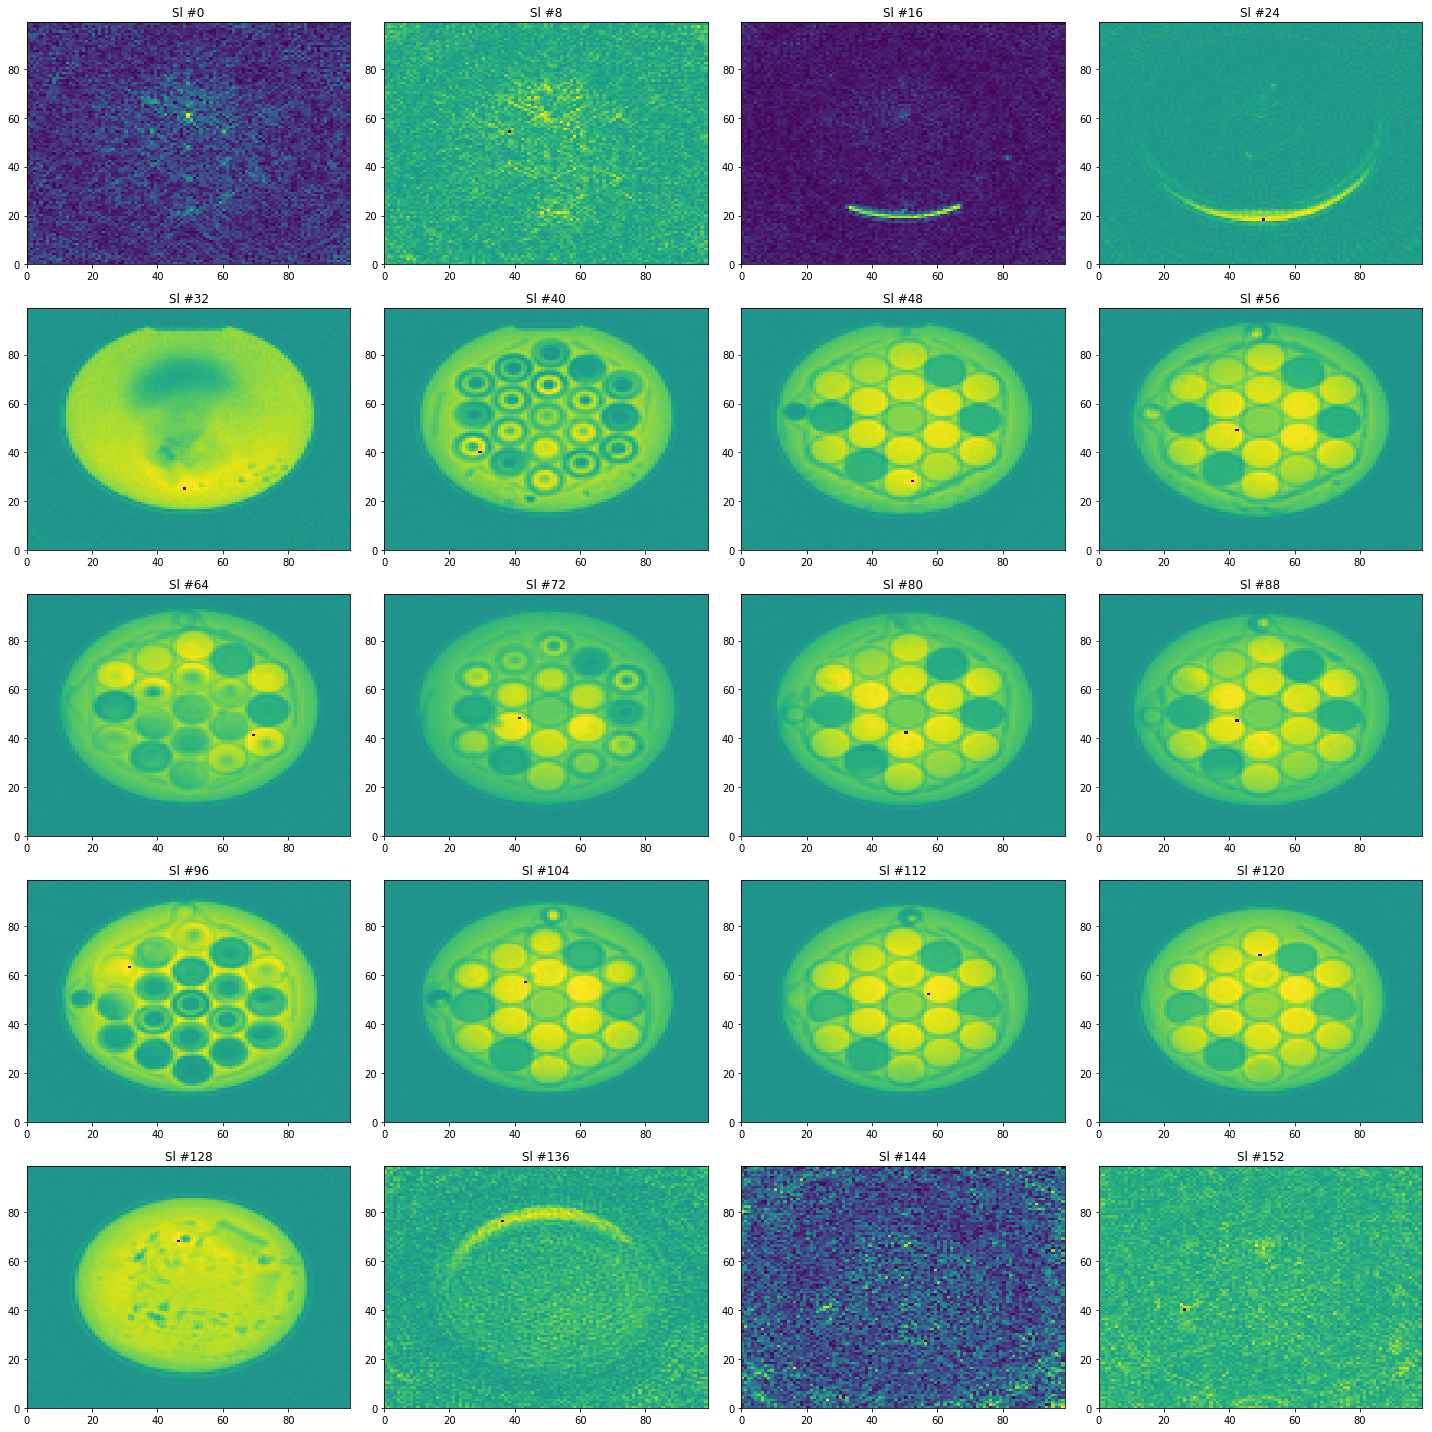

In [5]:
# Plot a few slices
plt.close()
vu.preview_volume_cplx(recon_ims_all_echoes[0,0,::])
plt.gcf().savefig('Preview_multislice_UTE_{:d}ms__cpx.png'.format(int(ute_list[0])))
plt.show()

### Select a slice to quantify
For first pass quantification select a single slice from the center assembly of containers in the phantom.

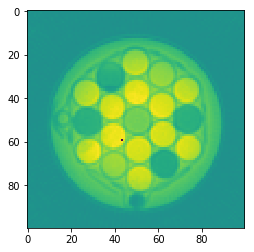

In [6]:
sli = 81

plt.close()
row, col, slc = vu.norm_mag_slice(recon_ims_all_echoes[0,0,::],sli,2)
plt.imshow(slc)
plt.show()

## Quantification

### Fitting procedure

#### 1. Fit magnitude
Fit the magnitude images for $TE<0.001$ using the following equation

$$ \frac{|S(\vec{r})|}{\max{|S(\vec{r})|}} = \rho [w_{short} \exp(-TE/T_{2, short}^{*}) + w_{long} \exp(-TE/T_{2, long}^{*})] $$

In [7]:
def mag_biexp_resid(params, utes, obs_sig):
    rho = params[0] # overall proton density
    
    w_short = params[1] # ultrashort T2*
    T2str_short = params[2]
    
    w_long = params[3] 
    T2str_long = params[4]
        
    S_hat = rho * ((w_short * np.exp((-1.0 * utes)/T2str_short)) + \
                   (w_long * np.exp((-1.0 * utes)/T2str_long)))
    res = S_hat - obs_sig
    return res


##### Prep data for magnitude fitting

In [8]:
# clip TE list (only use ultrashort TEs for mag fitting)
short_TEs = np.array([te for te in ute_list if (te < 0.001)])
print(len(short_TEs), short_TEs)

11 [2.40e-05 3.20e-05 5.20e-05 7.60e-05 1.12e-04 1.68e-04 2.48e-04 3.68e-04
 5.44e-04 8.04e-04 9.92e-04]


1.0


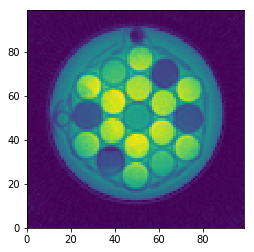

In [9]:
# collect data
slice_data = np.ndarray((nx, ny, len(short_TEs)), dtype=np.float64)
for TEi in range(len(short_TEs)):
    for xi in range(nx):
        for yi in range(ny):
            slice_data[xi, yi, TEi] = np.float64(np.abs(np.complex(
                *recon_ims_all_echoes[TEi,0,sli,yi,xi]
            )))
    
slice_data = slice_data/np.max(slice_data[:])
print(np.max(slice_data[:]))

plt.close()
plt.pcolormesh(range(nx),range(ny),slice_data[:,:,0])
plt.gca().set_aspect('equal')
plt.show()

##### Fitting Initialization
Initialize parameter estimates and bounds for parameters

In [10]:
# fit data

# Initialize parameter estimates
rho_est = 1.0

w_short_est = 0.25 # ~biological concentration of macromolecules (?)
T2str_short_est = 0.0005 # sec = 500 microsec

w_long_est = 0.75
T2str_long_est = 0.015 # sec = 15 millisec

param_est = np.array([rho_est, 
                      w_short_est, T2str_short_est, 
                      w_long_est, T2str_long_est])

# parameter bounds
rho_lb = 0
rho_ub = 2

w_short_lb = 0
w_short_ub = 1

T2str_short_lb = short_TEs[1] - short_TEs[0]
T2str_short_ub = short_TEs[-1] * 10

w_long_lb = 0
w_long_ub = 1

T2str_long_lb = short_TEs[1] - short_TEs[0]
T2str_long_ub = ute_list[-1] * 10

param_bnds = (
    [
        rho_lb,
        w_short_lb, T2str_short_lb,
        w_long_lb, T2str_long_lb
    ],
    [
        rho_ub,
        w_short_ub, T2str_short_ub,
        w_long_ub, T2str_long_ub
    ]
)


##### Voxel-wise fitting for slice

In [11]:
%%time
fit_results = np.ndarray((nx,ny,5)) # 5 parameters

for yi in range(ny):
    for xi in range(nx):
        result = least_squares(mag_biexp_resid, 
                               param_est, 
                               args=(short_TEs,
                                     slice_data[xi,yi,:]), 
                               bounds=param_bnds,
                               method='trf', verbose=0)
        
        fit_results[xi,yi,:] = result.x
        progress.update((yi * nx + xi)/(nx * ny))

progress.update(1)

Progress: [##################################################] 100.0%
CPU times: user 4min 41s, sys: 19.2 s, total: 5min
Wall time: 4min 46s


##### Plot initial fit results

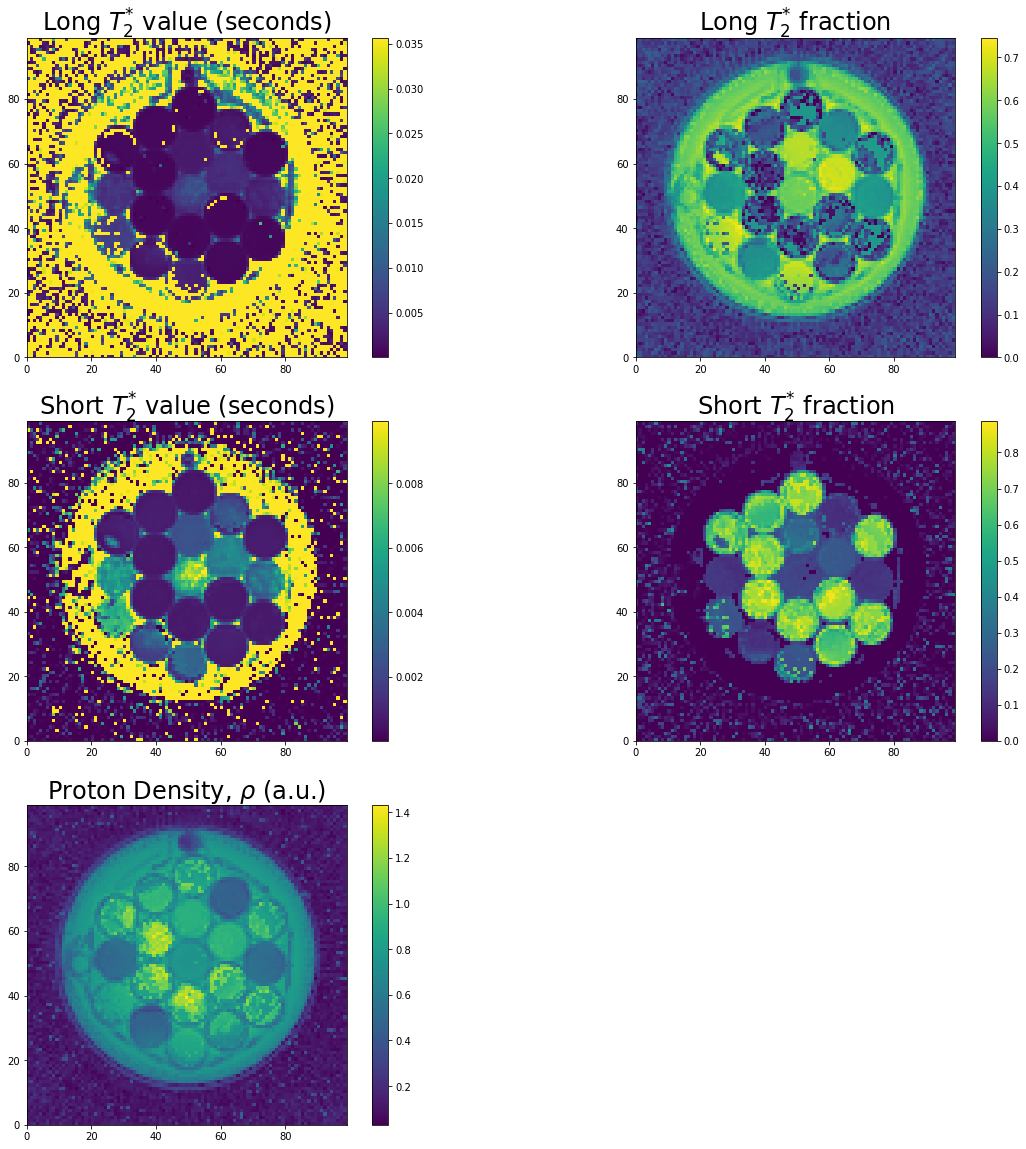

In [12]:
param_labels = [
    'Proton Density, $\\rho$ (a.u.)',
    'Short $T_{2}^{*}$ fraction',
    'Short $T_{2}^{*}$ value (seconds)',
    'Long $T_{2}^{*}$ fraction',
    'Long $T_{2}^{*}$ value (seconds)'
]
n_params = len(param_labels)

plt.close()
fig = plt.figure(figsize=(20,20))

for param_i in range(n_params):
    ax = fig.add_subplot(3,2,n_params - param_i)
    im = ax.pcolormesh(range(nx), range(ny), fit_results[:,:,param_i])
    ax.set_aspect('equal')
    ax.set_title(param_labels[param_i], fontsize=24)
    fig.colorbar(im, ax=ax)

plt.show()

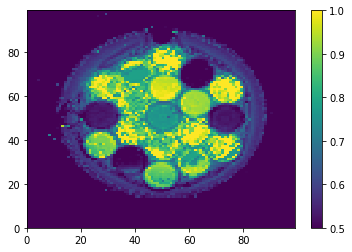

In [13]:
plt.close()
plt.pcolormesh(range(nx),range(ny),fit_results[:,:,1]+fit_results[:,:,3],
               vmin=0.5, vmax=1.0)
plt.colorbar()
plt.show()

##### Observations from initial fitting
1. Promising that pure water in the outer container (tap water for immersion) has reasonable proton density, and longer $T_{2}^{*}$ (high $w_{long}$, $T_{2,long}^{*}$, and even $T_{2,short}^{*}$)
2. what appears to be RF shading in inner ring of containers (from Proton Density map)
3. $w_{short} + w_{long} \neq 1$ (may need to constrain further)

#### 2. Fit complex signal model
The complex signal model includes terms for mapping of the $B_0$ field, and for fat-water seperation.

$$ 
\begin{eqnarray}\nonumber
\frac{S(\vec{r})}{\max{|S(\vec{r})|}} &=& \rho [w_{mac} \exp(-TE/T_{2,mac}^{*} - 2\pi i (\delta_{mac} + \gamma \Delta B_0) TE + i \phi_{RF,mac}) \\ && + w_{H_2O} \exp(-TE/T_{2,H_2O}^{*} - 2\pi i (\delta_{H_2O} + \gamma \Delta B_0) TE + i \phi_{RF,H_2O}) \\ && + w_{fat} \exp(-TE/T_{2,fat}^{*} - 2\pi i (\delta_{fat} + \gamma \Delta B_0) TE + i \phi_{RF,fat}) ]
\end{eqnarray}
$$

In [14]:
def cplx_triexp_resid(params, utes, obs_sig):
    i2pi = 1j * 2 * np.pi # useful complex constant
    
    rho = params[0] # overall proton density
    fm_Hz = params[1] # Fieldmap (Hz) = gamma * deltaB_0
    
    w_mac = params[2] # macromolecule fraction
    T2str_mac = params[3]
    cs_mac = params[4]
    phiRF_mac = params[5]
    
    w_H2O = params[6] 
    T2str_H2O = params[7]
    cs_H2O = 0 # FIXED
    phiRF_H2O = params[8]
    
    w_fat = 1.0 - (w_mac + w_H2O) # "FIXED" (computed so that sum(w_i) = 1)
    T2str_fat = params[9]
    cs_fat = params[10]
    phiRF_fat = params[11]
    
    S_hat = rho * ((w_mac * np.exp(((-1.0 * utes)/T2str_mac) - (i2pi * (cs_mac + fm_Hz) * utes) + (1j * phiRF_mac))) + \
                   (w_H2O * np.exp(((-1.0 * utes)/T2str_H2O) - (i2pi * (cs_H2O + fm_Hz) * utes) + (1j * phiRF_H2O))) + \
                   (w_fat * np.exp(((-1.0 * utes)/T2str_fat) - (i2pi * (cs_fat + fm_Hz) * utes) + (1j * phiRF_fat))))
    res = S_hat - obs_sig
    return np.array([res.real, res.imag]).T.flatten()


##### Prep data for complex fitting

0.9999999999999999


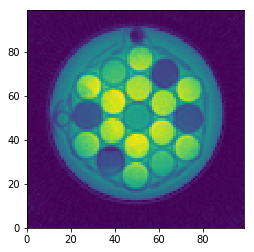

In [15]:
# collect data
slice_data = np.ndarray((nx, ny, len(ute_list)), dtype=np.complex)
for TEi in range(len(ute_list)):
    for xi in range(nx):
        for yi in range(ny):
            slice_data[xi, yi, TEi] = np.complex(
                *recon_ims_all_echoes[TEi,0,sli,yi,xi]
            )
    
slice_data = slice_data/np.max(np.abs(slice_data[:]))
print(np.max(np.abs(slice_data[:])))

plt.close()
plt.pcolormesh(range(nx),range(ny),np.abs(slice_data[:,:,0]))
plt.gca().set_aspect('equal')
plt.show()

##### Fitting Initialization
Initialize parameter estimates and set bounds for parameters

In [16]:
n_params = 12

_PROTON_GYROMAGNETIC_RATIO = 42.577478518e6 # Hz/T (NIST: https://physics.nist.gov/cgi-bin/cuu/Value?gammapbar)
_B0 = 3.0 # T

# Initialize parameter estimate maps (voxelwise)
param_est_slc = np.ndarray((nx, ny, n_params))

for yi in range(ny):
    for xi in range(nx):
        param_est = np.ndarray((n_params,))
        
        param_est[0] = fit_results[xi, yi, 0] # rho = rho from mag fit
        param_est[1] = 0 # fm_Hz - assume no B_0 inhomogeneity
        
        param_est[2] = fit_results[xi, yi, 1] # w_mac - assumed to be ultrashort T2* component
        param_est[3] = fit_results[xi, yi, 2] # T2str_mac = T2str_short
        param_est[4] = 0 # cs_mac - assume no chemical shift for initialization
        param_est[5] = 0.0562 # phiRF_mac - assumption duplicates UTEMRI_Brain fitting code from Peder & Nikhil (uT2 phase)
        
        param_est[6] = fit_results[xi, yi, 3] * 0.8 # w_H2O - assume 80% of long T2str component is water
        param_est[7] = fit_results[xi, yi, 4] # T2str_H2O = T2str_long
        param_est[8] = 0 # phiRF_H2O - assumption duplicates UTEMRI_Brain fitting code from Peder & Nikhil (long T2 phase)
        
        param_est[9] = fit_results[xi, yi, 4] # T2str_fat = T2str_long (maybe scale down by some fraction?)
        param_est[10] = (3.5 / 1e6) * (_B0 * _PROTON_GYROMAGNETIC_RATIO) # cs_fat = 3.5 ppm -> Hz (fat chemical shift)
        param_est[11] = 0 # phiRF_fat - not sure if this is accurate
        
        param_est_slc[xi, yi, :] = param_est


# parameter bounds
rho_lb = 0
rho_ub = 2

fm_Hz_lb = -400 # Hz
fm_Hz_ub = 400

# ~*~*~ Macromolecule component ~*~*~
w_mac_lb = 0 # should maybe make this +/- some % of initial value (?)
w_mac_ub = 1

T2str_mac_lb = short_TEs[1] - short_TEs[0] # should maybe make this +/- 15% of initial value (?)
T2str_mac_ub = short_TEs[-1] * 10

cs_mac_lb = -2000 # uhhh... ¯\_(ツ)_/¯
cs_mac_ub = 2000

phiRF_mac_lb = -50 # +/- 0.05 kHz -> +/- 50 Hz (from Peder & Nikhil's code)
phiRF_mac_ub = 50

# ~*~*~ H2O component ~*~*~
w_H2O_lb = 0 # make this % of initial value? (will require more maps)
w_H2O_ub = 1

T2str_H2O_lb = short_TEs[1] - short_TEs[0]
T2str_H2O_ub = ute_list[-1] * 10

phiRF_H2O_lb = -50
phiRF_H2O_ub = 50

# ~*~*~ Fat component ~*~*~
T2str_fat_lb = short_TEs[1] - short_TEs[0]
T2str_fat_ub = ute_list[-1] * 10

cs_fat_lb = -2000
cs_fat_ub = 2000

phiRF_fat_lb = -50
phiRF_fat_ub = 50

param_bnds = (
    [
        rho_lb, fm_Hz_lb, 
        w_mac_lb, T2str_mac_lb, cs_mac_lb, phiRF_mac_lb, 
        w_H2O_lb, T2str_H2O_lb, phiRF_H2O_lb, 
        T2str_fat_lb, cs_fat_lb, phiRF_fat_lb
    ],
    [
        rho_ub, fm_Hz_ub, 
        w_mac_ub, T2str_mac_ub, cs_mac_ub, phiRF_mac_ub, 
        w_H2O_ub, T2str_H2O_ub, phiRF_H2O_ub, 
        T2str_fat_ub, cs_fat_ub, phiRF_fat_ub
    ]
)


##### Voxel-wise fitting for slice

In [17]:
%%time
fit_results_2 = np.ndarray((nx,ny,n_params)) # 5 parameters

for yi in range(ny):
    for xi in range(nx):
        result = least_squares(cplx_triexp_resid, 
                               param_est_slc[xi, yi, :], 
                               args=(np.array(ute_list),
                                     slice_data[xi,yi,:]), 
                               bounds=param_bnds,
                               method='trf', verbose=0)
        
        fit_results_2[xi,yi,:] = result.x
        progress.update((yi * nx + xi)/(nx * ny))

progress.update(1)

Progress: [##################################################] 100.0%
CPU times: user 42min 34s, sys: 12.1 s, total: 42min 46s
Wall time: 42min 48s


##### Plot fit results

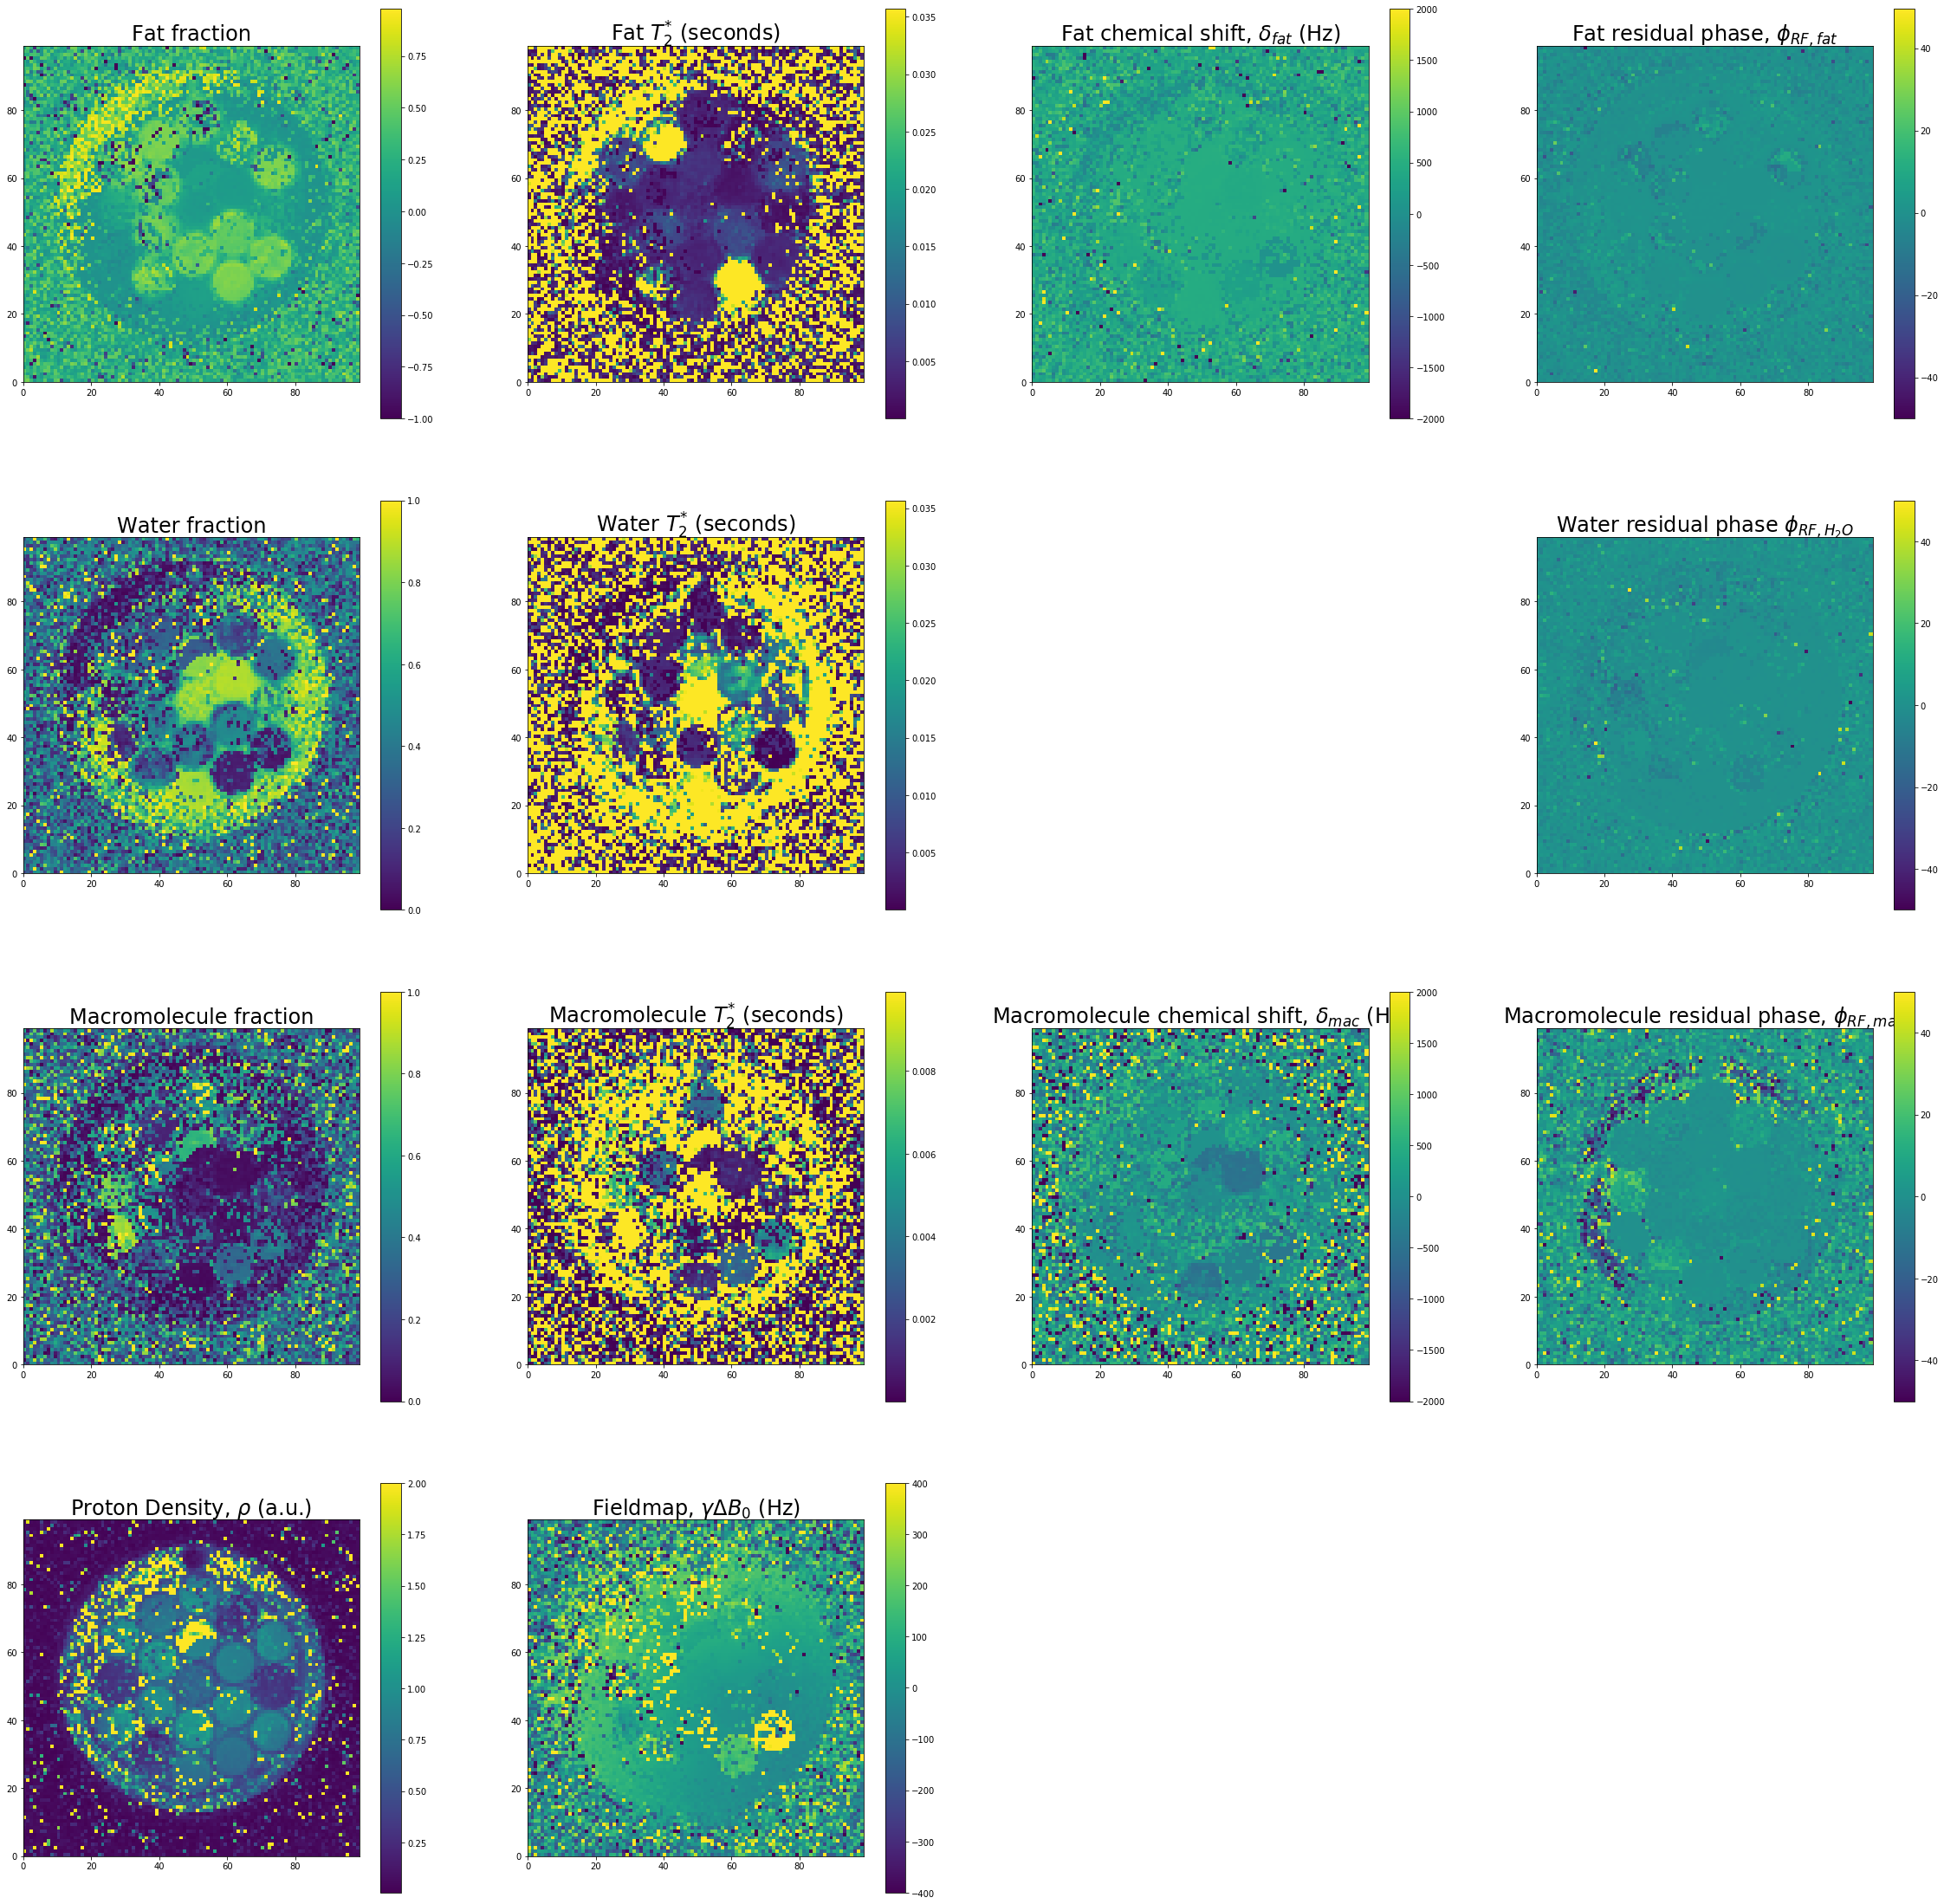

In [18]:
param_labels = [
    'Proton Density, $\\rho$ (a.u.)',
    'Fieldmap, $\\gamma\\Delta B_0$ (Hz)',
    'Macromolecule fraction',
    'Macromolecule $T_{2}^{*}$ (seconds)',
    'Macromolecule chemical shift, $\\delta_{mac}$ (Hz)',
    'Macromolecule residual phase, $\\phi_{RF,mac}$',
    'Water fraction',
    'Water $T_{2}^{*}$ (seconds)',
    'Water residual phase $\\phi_{RF,H_2O}$',
    'Fat $T_{2}^{*}$ (seconds)',
    'Fat chemical shift, $\\delta_{fat}$ (Hz)',
    'Fat residual phase, $\\phi_{RF,fat}$'
]

plot_indices = [
    13,
    14,
    9,
    10,
    11,
    12,
    5,
    6,
    8,
    2,
    3,
    4
]

n_params = len(param_labels)

plt.close()
fig = plt.figure(figsize=(40,40))

# plot w_fat separately (computed not stored in fit_results_2)
ax = fig.add_subplot(4,4,1)
im = ax.pcolormesh(range(nx), range(ny), 1.0 - (fit_results_2[:,:,2] + fit_results_2[:,:,6]))
ax.set_aspect('equal')
ax.set_title('Fat fraction', fontsize=24)
fig.colorbar(im, ax=ax)

for param_i in range(n_params):
    ax = fig.add_subplot(4,4,plot_indices[param_i])
    im = ax.pcolormesh(range(nx), range(ny), fit_results_2[:,:,param_i])
    ax.set_aspect('equal')
    ax.set_title(param_labels[param_i], fontsize=24)
    fig.colorbar(im, ax=ax)

plt.show()